In [1]:
import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) /'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(sys.path)
from ICL import MultiResolutionPDF

['/home/abenechehab/miniconda3/envs/LLMICL/lib/python39.zip', '/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9', '/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/lib-dynload', '', '/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages', '/home/abenechehab/llmicl/src', '/home/abenechehab/llmicl/src/llmicl/legacy', '../models']


In [2]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    print(f"[{index}]: {file.name}")

[0]: brownian_motion_0.pkl
[1]: brownian_motion_1.pkl
[2]: brownian_motion_10.pkl
[3]: brownian_motion_11.pkl
[4]: brownian_motion_12.pkl
[5]: brownian_motion_13.pkl
[6]: brownian_motion_14.pkl
[7]: brownian_motion_15.pkl
[8]: brownian_motion_16.pkl
[9]: brownian_motion_17.pkl
[10]: brownian_motion_18.pkl
[11]: brownian_motion_19.pkl
[12]: brownian_motion_2.pkl
[13]: brownian_motion_3.pkl
[14]: brownian_motion_4.pkl
[15]: brownian_motion_5.pkl
[16]: brownian_motion_6.pkl
[17]: brownian_motion_7.pkl
[18]: brownian_motion_8.pkl
[19]: brownian_motion_9.pkl
[20]: correlated_gaussian_0.pkl
[21]: correlated_gaussian_1.pkl
[22]: correlated_gaussian_2.pkl
[23]: correlated_gaussian_3.pkl
[24]: correlated_gaussian_4.pkl
[25]: correlated_gaussian_5.pkl
[26]: correlated_gaussian_6.pkl
[27]: correlated_gaussian_7.pkl
[28]: correlated_gaussian_8.pkl
[29]: correlated_gaussian_9.pkl
[30]: geometric_brownian_motion_0.pkl
[31]: geometric_brownian_motion_1.pkl
[32]: geometric_brownian_motion_10.pkl
[33]:

In [3]:
alpha = 1
# alpha = 6

file = all_files[0] # neighbor depth 2
# file = all_files[1] # neighbor depth 2

print(f"file: {file}")

processed_dict = pickle.load(file.open('rb'))
full_series = processed_dict['full_series']
rescaled_true_mean_arr = processed_dict['rescaled_true_mean_arr']
rescaled_true_sigma_arr = processed_dict['rescaled_true_sigma_arr']
llama_size = processed_dict['llama_size']
mode = processed_dict['mode']
refine_depth = processed_dict['refine_depth']
random_seed = processed_dict['random_seed']
PDF_list = processed_dict['PDF_list']
time_series = processed_dict['time_series']
prec = processed_dict['prec']
print(f"seed: {processed_dict['random_seed']}")
print(f"mode: {mode}")
print(f"refine_depth: {refine_depth}")
print(f"prec: {prec}")
print(f"name: {file.stem}")

file: /home/abenechehab/llmicl/src/llmicl/legacy/processed_series/brownian_motion_0.pkl
seed: 5
mode: neighbor
refine_depth: 2
prec: 3
name: brownian_motion_0


In [4]:
### tune temperature 

for PDF in PDF_list:
    if alpha != 1:
        PDF.rescale_temperature(alpha)

In [5]:
# PDF_list = PDF_list[0]

In [6]:
### Calculate true discretized distribution: PDF_list_true
### Compute discretized BT and KL loss

PDF_true_list = copy.deepcopy(PDF_list)
discrete_BT_loss = []
discrete_KL_loss = []
for PDF, PDF_true, true_mean, true_sigma in zip(PDF_list, PDF_true_list, rescaled_true_mean_arr, rescaled_true_sigma_arr):
    def cdf(x):
        return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
    
    PDF_true.discretize(cdf, mode = "cdf")
    PDF_true.compute_stats()
    discrete_BT_loss += [PDF_true.BT_dist(PDF)]    
    discrete_KL_loss += [PDF_true.KL_div(PDF)]

discrete_BT_loss = np.array(discrete_BT_loss)
discrete_KL_loss = np.array(discrete_KL_loss)

### Extract statistics from MultiResolutionPDF

mean_arr = []
mode_arr = []
sigma_arr = []
moment_3_arr = []
moment_4_arr = []

num_commas = full_series.count(',')
for comma_idx in range(num_commas):
    PDF_list[comma_idx].compute_stats()
    mean, mode, sigma = PDF_list[comma_idx].mean, PDF_list[comma_idx].mode, PDF_list[comma_idx].sigma 
    moment_3 = PDF_list[comma_idx].compute_moment(3)
    moment_4 = PDF_list[comma_idx].compute_moment(4)
    
    mean_arr.append(mean)
    mode_arr.append(mode)
    sigma_arr.append(sigma)
    moment_3_arr.append(moment_3)
    moment_4_arr.append(moment_4)

# Convert lists to numpy arrays
mean_arr = np.array(mean_arr)
mode_arr = np.array(mode_arr)
sigma_arr = np.array(sigma_arr)
moment_3_arr = np.array(moment_3_arr)
moment_4_arr = np.array(moment_4_arr)
kurtosis_arr = moment_4_arr / sigma_arr**4
kurtosis_error = (kurtosis_arr-3)**2

error_mean = np.abs(rescaled_true_mean_arr - mean_arr)
error_mode = np.abs(rescaled_true_mean_arr - mode_arr)

/tmp/ipykernel_1441245/2555006602.py:9: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr


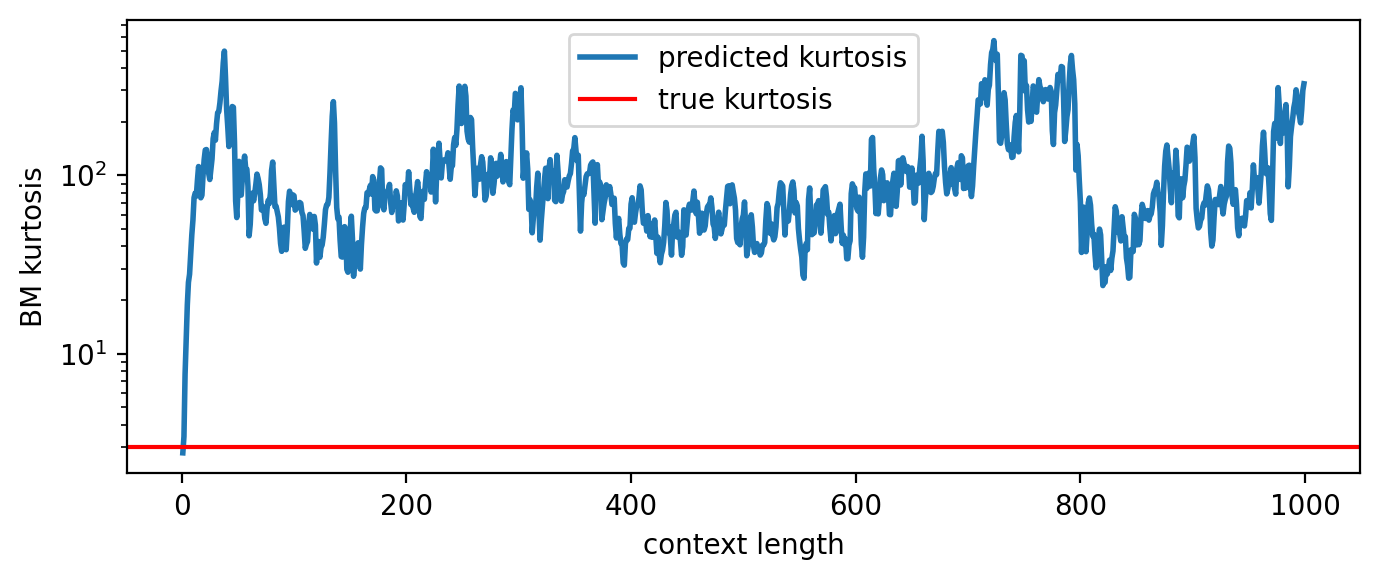

In [7]:
### Plot kurtosis
plt.figure(figsize=(7, 3), dpi = 200)
window_size = 2


top_hat_kernel = np.ones(window_size) / window_size
averaged_kurtosis_arr = np.convolve(kurtosis_arr, top_hat_kernel, mode='valid')
averaged_kurtosis_error = np.convolve(kurtosis_error, top_hat_kernel, mode='valid')

plt.plot(np.arange(window_size//2, len(kurtosis_arr) - window_size//2 + 1), averaged_kurtosis_arr, linewidth=2, label = 'predicted kurtosis')
# ax1.plot(kurtosis_arr)
plt.axhline(y=3, color='r', linestyle='-', label = 'true kurtosis')
# plt.plot(averaged_kurtosis_error, label = 'kurtosis error', c = "black")

plt.xlabel('context length')
plt.ylabel(r'BM kurtosis')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig(f'../figures/BM_kurtosis_temp{alpha}.png')


/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:596: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


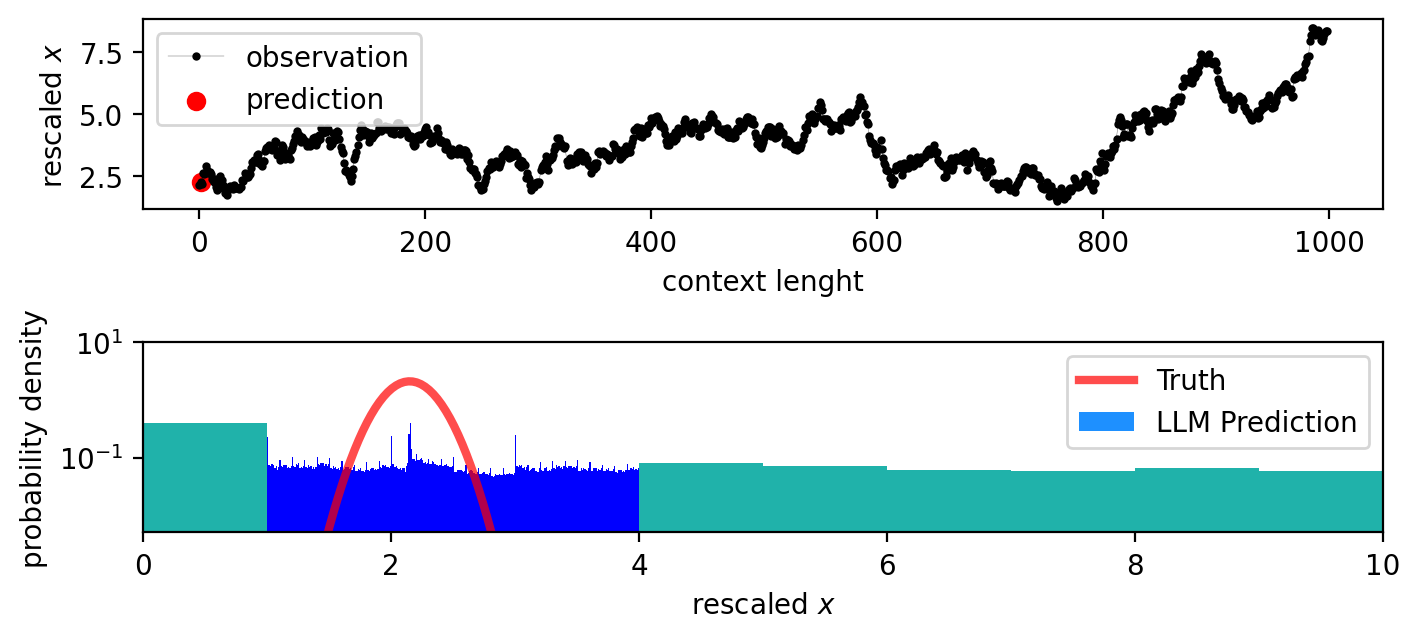

interactive(children=(IntSlider(value=1, description='comma_idx', max=999, min=1), Output()), _dom_classes=('w…

In [8]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import norm
save_path = f"../figures/BM_example_temp{alpha}.png"
### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])
time_series_rescaled = (time_series-time_series.min()) / (time_series.max()-time_series.min()) * (8.5-1.5) + 1.5

plot1_log_scale = 0
log_scale = 1
truth_PDF = 0
# final_state = 709
final_state = None

### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1
    if truth_PDF:
        fig, axs = plt.subplots(3, 1, figsize=(8, 5), dpi = 200)
    else:
        fig, axs = plt.subplots(2, 1, figsize=(8, 10/3), dpi = 200)
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.7)
    # Plot the full array with a marker on the selected value
    if final_state is not None:
        time_series_plot = time_series_rescaled[:final_state+1]
        axs[0].set_xlim(-10, final_state+10)
    else:
        time_series_plot = time_series_rescaled
    axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw = '0.1', label = "observation")
    axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label = "prediction")
    axs[0].set_xlabel('context lenght')
    axs[0].set_ylabel(r'rescaled $x$')
    
    if plot1_log_scale:
        axs[0].set_yscale('log')
        
    # Plot softmax distributions for each digit
    axs[1].set_ylabel("probability density")
    # axs[1].set_title(full_series[start_idx-30:start_idx] + "?")      
    PDF_list[comma_idx].compute_stats()
    PDF_list[comma_idx].plot(ax = axs[1], log_scale=log_scale, statistic = False)
    if truth_PDF:
        PDF_true_list[comma_idx].plot(ax = axs[2], log_scale=log_scale, statistic = False)
        axs[2].set_title('discretized truth')
        axs[2].set_xlabel("Digit")
    
    # characterizing ground truth distribution
    true_mean = rescaled_true_mean_arr[comma_idx]
    true_sigma = rescaled_true_sigma_arr[comma_idx]
    if true_sigma == 0:
        axs[1].vlines(true_mean, 0, np.max(PDF_list[comma_idx].bin_height_arr), color='r', label='Truth', lw = 3, alpha = 0.7)
    else:
        x_values = np.linspace(0, 10, 300)
        gaussian = norm.pdf(x_values, true_mean, true_sigma)
        axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth', lw = 3, alpha = 0.7)
        # axs[1].vlines(true_mean, 0, np.max(gaussian), color = 'r')
    # axs[1].set_ylim(np.min(pdf.bin_height_arr), np.max(gaussian)*1.7)
    axs[1].set_xlabel(r'rescaled $x$')
    axs[1].bar([0], [0], color='dodgerblue', label='LLM Prediction')
    axs[1].set_xlim(0,10)
    # axs[1].set_ylim(0,5)
    axs[0].legend()
    axs[1].legend()
    if log_scale:
        axs[1].set_ylim(0.005,10)
        if truth_PDF:
            axs[2].set_ylim(0.0005,10)
    if final_state is not None: 
        plt.tight_layout()
        plt.savefig(save_path)

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
if final_state is not None: 
    interact(digiprob_plotter, comma_idx=final_state)
else:
    interact(digiprob_plotter, comma_idx=(1, num_commas-1, 1))

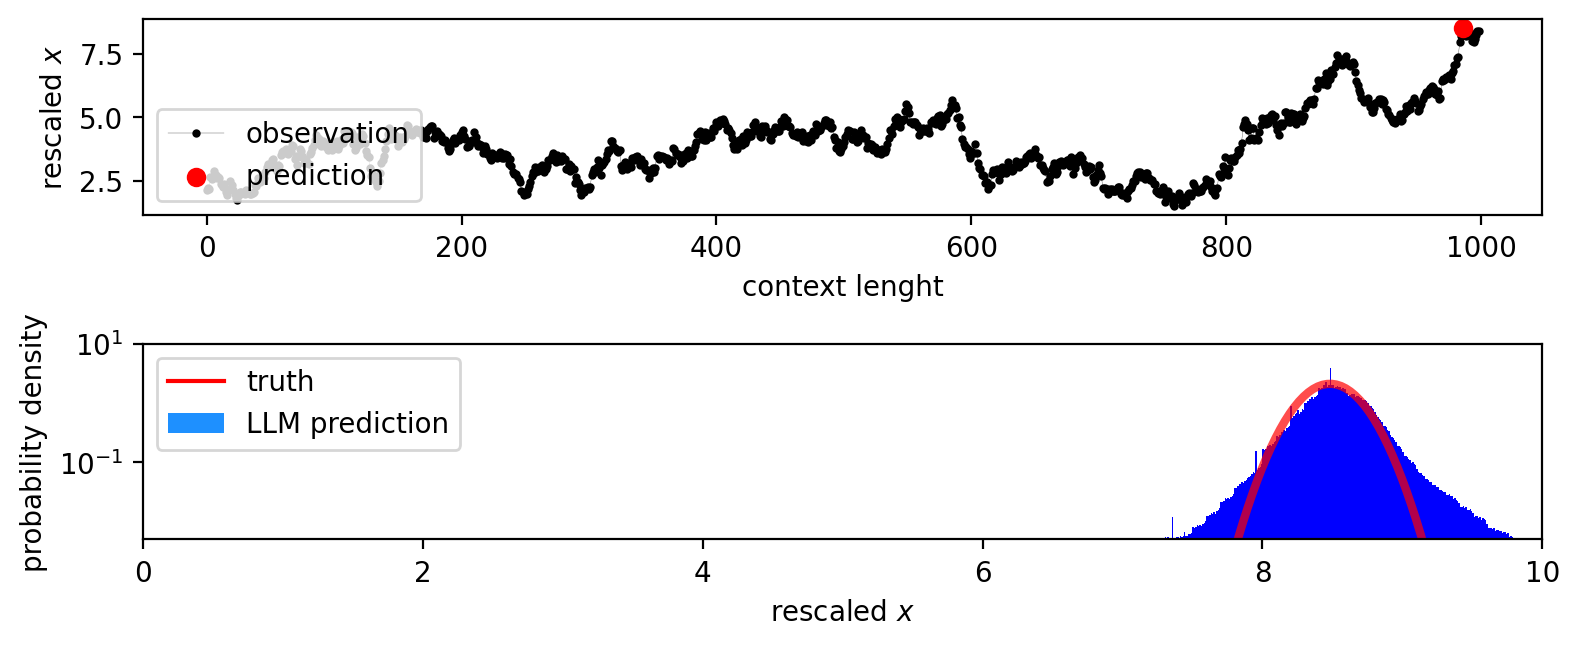

interactive(children=(IntSlider(value=986, description='comma_idx', max=2958, min=-986), Output()), _dom_class…

In [9]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import norm
import copy


### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])
time_series_rescaled = (time_series-time_series.min()) / (time_series.max()-time_series.min()) * (8.5-1.5) + 1.5

plot1_log_scale = 0
log_scale = 1
temp_list = [1]
final_state = None
filenames = []
### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1

    fig, axs = plt.subplots(1+len(temp_list), 1, figsize=(8, 5/3*(1+len(temp_list))), dpi = 200)
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.7)
    # Plot the full array with a marker on the selected value
    if final_state is not None:
        time_series_plot = time_series_rescaled[:final_state+1]
    else:
        time_series_plot = time_series_rescaled
    # axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label = "prediction")
    # axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw = '0.1', label = "observation")
    axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw='0.1', label="observation", zorder=1)
    axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label="prediction", zorder=2)
    axs[0].set_xlabel('context lenght')
    axs[0].set_ylabel(r'rescaled $x$')
    if final_state is not None:
        axs[0].set_xlim(-10, final_state+10)
    if plot1_log_scale:
        axs[0].set_yscale('log')
        
        
    for i, temp in enumerate(temp_list):
    # Plot softmax distributions for each digit
        axs[i+1].set_ylabel("probability density")
        if len(temp_list) > 1:
            axs[i+1].set_title(f"LLM temperature = {temp}") 
        
        PDF_copied = copy.deepcopy(PDF_list[comma_idx])
        PDF_copied.rescale_temperature(temp)
        PDF_copied.compute_stats()
        PDF_copied.plot(ax = axs[i+1], log_scale=log_scale, statistic = False)
        if log_scale:
            axs[1].set_ylim(0.005,10)

        # characterizing ground truth distribution
        true_mean = rescaled_true_mean_arr[comma_idx]
        true_sigma = rescaled_true_sigma_arr[comma_idx]
        if true_sigma == 0:
            axs[i+1].vlines(true_mean, 0, np.max(PDF_list[comma_idx].bin_height_arr), color='r', label='Truth', lw = 3, alpha = 0.7)
        else:
            x_values = np.linspace(0, 10, 300)
            gaussian = norm.pdf(x_values, true_mean, true_sigma)
            axs[i+1].plot(x_values, gaussian, color = 'r', lw = 3, alpha = 0.7)

        # axs[1].bar([0], [0], lw = 3, color='lightseagreen', label='bin of width 1')
        # axs[1].bar([0], [0], lw = 3, color='blue', label='bin of width 0.01')
        axs[1].bar([0], [0], lw = 3, color='dodgerblue', label='LLM prediction')
        axs[1].plot([0], [0], color='r', label='truth')
        
        axs[i+1].set_xlabel(r'rescaled $x$')
        axs[i+1].legend()
        axs[i+1].set_xlim(0,10)
        if len(temp_list) > 1:
            axs[i+1].set_ylim(0,2.6)    
        

    axs[0].legend(loc="lower left")

    plt.tight_layout()
    save_path = f"../figures/BM_example_snapshot_{comma_idx}.png"
    filenames.append(save_path)
    plt.savefig(save_path)

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
snapshots = [1,2,3,4,5,6,10,100,200,300,400,500,600,700,800,900,986]
for snapshot in snapshots:
    interact(digiprob_plotter, comma_idx=snapshot)


In [10]:
# Create a GIF using snapshot made
import imageio.v2 as imageio

with imageio.get_writer('../figures/BM_snapshots_llama3_temp.gif', mode='I', duration=500, loop=0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)